In [1]:
%matplotlib inline
import torch
import numpy as np
import torch
from torch import nn,optim
import torchvision
from PIL import Image
import time
import sys
sys.path.append('../code/')
import d2lzh_pytorch as d2l

import os
data_dir='../data/pikachu/'
assert os.path.exists(os.path.join(data_dir,'train'))

In [2]:
def cls_predictor(in_channels,num_anchors,num_classes):
    return nn.Conv2d(in_channels=in_channels,out_channels=num_anchors*(num_classes+1),kernel_size=3,padding=1)

In [3]:
def bbox_predictor(in_channels,num_anchors):
    return nn.Conv2d(in_channels=in_channels,out_channels=num_anchors*4,kernel_size=3,padding=1)

In [4]:
def forward(x,block):
    return block(x)

Y1=forward(torch.zeros((2,8,20,20)),cls_predictor(8,5,10))
Y2=forward(torch.zeros((2,16,10,10)),cls_predictor(16,3,10))
(Y1.shape,Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [5]:
def flatten_pred(pred):
    return pred.permute(0,2,3,1).contiguous().view(pred.shape[0],-1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds],dim=1)

In [6]:
concat_preds([Y1,Y2]).shape

torch.Size([2, 25300])

In [7]:
def down_sample_blk(in_channels,num_channels):
    blk=nn.Sequential()

    blk.add_module('conv',nn.Conv2d(in_channels=in_channels,out_channels=num_channels,kernel_size=3,padding=1))
    blk.add_module('bn',nn.BatchNorm2d(num_channels))
    blk.add_module('relu',nn.ReLU()) 
    blk.add_module('conv1',nn.Conv2d(in_channels=num_channels,out_channels=num_channels,kernel_size=3,padding=1))
    blk.add_module('bn1',nn.BatchNorm2d(num_channels))
    blk.add_module('relu1',nn.ReLU())
    blk.add_module('max_pooling',nn.MaxPool2d(2))
    
    return blk

In [8]:
forward(torch.zeros((2,3,20,20)),down_sample_blk(3,10)).shape

torch.Size([2, 10, 10, 10])

In [9]:
def base_net(in_channels):
    blk=nn.Sequential()
    blk.add_module('d1',down_sample_blk(in_channels,16))
    blk.add_module('d2',down_sample_blk(16,32))
    blk.add_module('d3',down_sample_blk(32,64))
    
    return blk

In [10]:
forward(torch.zeros((2,3,256,256)),base_net(3)).shape

torch.Size([2, 64, 32, 32])

In [11]:
def get_blk(i,in_channels):
    if i==0:
        blk=base_net(in_channels)
    elif i==4:
        blk=nn.AdaptiveMaxPool2d(1)
    elif i==1:
        blk=down_sample_blk(64,128)
    else:
        blk=down_sample_blk(128,128)
    return blk

In [12]:
def blk_forward(X,blk,size,ratio,cls_predictor,bbox_predictor):
    Y=blk(X)
    anchors=d2l.MultiBoxPrior(Y,size,ratio)
    cls_preds=cls_predictor(Y)
    bbox_preds=bbox_predictor(Y)
    return (Y,anchors,cls_preds,bbox_preds)

In [13]:
sizes=[[0.2,0.272],[0.37,0.447],[0.54,0.619],[0.71,0.79],[0.88,0.961]]
ratios=[[1,2,0.5]]*5
num_anchors=len(sizes[0])+len(ratios[0])-1

In [14]:
class TinySSD(nn.Module):
    def __init__(self,num_classes,in_channels=3,**kwargs):
        super(TinySSD,self).__init__(**kwargs)
        self.num_classes=num_classes
        self.in_channels=in_channels
        for i in range(5):
            if i==0:
                setattr(self,'blk_%d' % i,get_blk(i,in_channels))
                setattr(self,'cls_%d' % i,cls_predictor(64,num_anchors,num_classes))
                setattr(self,'bbox_%d' % i,bbox_predictor(64,num_anchors))
            else:
                setattr(self,'blk_%d' % i,get_blk(i,in_channels))
                setattr(self,'cls_%d' % i,cls_predictor(128,num_anchors,num_classes))
                setattr(self,'bbox_%d' % i,bbox_predictor(128,num_anchors))
                
    def forward(self,X):
        anchors,cls_preds,bbox_preds=[None]*5,[None]*5,[None]*5
        for i in range(5):
            X,anchors[i],cls_preds[i],bbox_preds[i]=blk_forward(X,
                getattr(self,'blk_%d' % i),sizes[i],ratios[i],
                getattr(self,'cls_%d' % i),getattr(self,'bbox_%d' % i))
        return (torch.cat(anchors,dim=1),
                concat_preds(cls_preds).view((X.shape[0],-1,self.num_classes+1)),
                concat_preds(bbox_preds))

In [15]:
net=TinySSD(num_classes=1)
X=torch.zeros((32,3,256,256))
anchors,cls_preds,bbox_preds=net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [16]:
batch_size=16
train_iter,test_iter=d2l.load_data_pikachu(batch_size,data_dir='../data/pikachu/')

In [17]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net=TinySSD(num_classes=1)
optimizer=optim.SGD(net.parameters(),lr=0.2,weight_decay=5e-4)

In [18]:
cls_loss=nn.CrossEntropyLoss()
bbox_loss=nn.L1Loss()

def calc_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks):
    #print(cls_preds.shape)
    #print(cls_labels.shape)
    cls=cls_loss(cls_preds.view((-1,cls_preds.shape[-1])),cls_labels.view((-1)))
    bbox=bbox_loss(bbox_preds*bbox_masks,bbox_labels*bbox_masks)
    return 0.2*cls+bbox

In [19]:
def cls_eval(cls_preds,cls_labels):
    return (cls_preds.argmax(dim=-1)==cls_labels).sum().item()

In [20]:
def bbox_eval(bbox_preds,bbox_labels,bbox_masks):
    return ((bbox_labels-bbox_preds)*bbox_masks).abs().sum().item()

In [21]:
batch=iter(test_iter).next()

In [22]:
batch['label'].shape

torch.Size([16, 1, 5])

In [23]:
epochs=20

In [24]:
def train_ssd(epochs,net,train_iter,optimizer):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    for epoch in range(epochs):
        start=time.time()
        for batch in train_iter:
            X=batch['image']
            y=batch['label']
            X=X.to(device)
            y=y.to(device)
            net=net.to(device)
            anchors, cls_preds, bbox_preds = net(X)
            '''print(anchors.shape)
            print(cls_preds.shape)
            print(bbox_preds.shape)
            for j in range(cls_preds.shape[1]):
                if cls_preds[0,j,1]>cls_preds[0,j,0]:
                    print(cls_preds[0,j,:])'''
                
            bbox_labels,bbox_masks,cls_labels=d2l.MultiBoxTarget(
                anchors,y)
            #print(cls_preds.shape)
            #print(cls_labels.shape)
            '''print(bbox_labels.shape)
            print(bbox_masks.shape)
            print(cls_labels.shape)'''
            bbox_labels,bbox_masks,cls_labels=bbox_labels.to(device),bbox_masks.to(device),cls_labels.to(device)
            l=calc_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            acc_sum += cls_eval(cls_preds, cls_labels)
            #print(acc_sum)
            n += cls_labels.shape[0]*cls_labels.shape[1]
            #print(n)
            mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
            m += bbox_labels.shape[0]*bbox_labels.shape[1]
    #if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
        epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

In [25]:
a=torch.tensor([[[1000.0,1,2,3,4,5],
                 [1,1000,2,3,4,5]]])
b=torch.tensor([[0,1]],dtype=torch.long)
print(a.shape)
print(b.shape)
nn.CrossEntropyLoss()(a.view((-1,a.shape[-1])),b.view((-1)))
#a.view((-1,a.shape[-1]))

torch.Size([1, 2, 6])
torch.Size([1, 2])


tensor(0.)

In [ ]:
train_ssd(epochs,net,train_iter,optimizer)

epoch  1, class err 1.12e-01, bbox mae 6.24e-04, time 71.2 sec
epoch  2, class err 6.05e-02, bbox mae 6.18e-04, time 70.0 sec


In [34]:
img=Image.open('../data/pikachu/pikachu.jpg').convert('RGB')
#img=Image.open('../data/pikachu/val/images/1.png').convert('RGB')
loader = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.ToTensor()
    ]) 
feature =loader(img)
X = feature.unsqueeze(0)
X.shape

torch.Size([1, 3, 256, 256])

In [35]:
batch['image'].shape

torch.Size([16, 3, 256, 256])

In [47]:
def predict(X):
    anchors, cls_preds, bbox_preds = net.to(device)(X.to(device))
    anchors, cls_preds, bbox_preds=anchors.to(torch.device('cpu')), cls_preds.to(torch.device('cpu')), bbox_preds.to(torch.device('cpu'))
    '''for i in range(5444):
        #print(cls_preds[0,i,:])
        #print(cls_preds.softmax(dim=2)[0,i,:])
        if cls_preds[0,i,1].item()>cls_preds[0,i,0].item():
            print(i)
        #cls_preds.softmax(dim=2)[0,i,:]
    '''
    cls_probs = cls_preds.softmax(dim=-1).permute((0, 2, 1))
    output = d2l.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    #idx = [i for i, row in enumerate(output[0]) if row[0].item() != -1]
    #return (output,output[0, idx])
    return output

In [52]:
output= predict(X)

In [53]:
output

tensor([[[-1.0000,  0.9772,  0.7039, -1.2836,  0.8976,  0.4111],
         [-1.0000,  0.9818, -0.2282, -0.4354, -0.0850, -0.1534],
         [-1.0000,  0.9887, -0.0675,  0.5538,  0.1810,  0.4124],
         ...,
         [-1.0000,  0.6571, -0.4201, -0.1812,  1.1433,  0.7381],
         [-1.0000,  0.5755, -0.3102, -0.8346,  0.8159,  0.6820],
         [-1.0000,  0.5701, -0.5250, -0.4576,  1.2504,  0.2714]]])

In [54]:
idx = [i for i, row in enumerate(output[0]) if row[0].item() != -1]
output[0, idx].shape

torch.Size([0, 6])

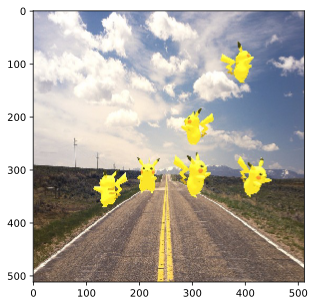

In [55]:
d2l.set_figsize((5, 5))
def display(img, output, threshold):
    fig = d2l.plt.imshow(img)
    for row in output:
        score = row[1].item()
        if score < threshold:
            continue
        feature =loader(img)
        h, w = feature.shape[1],feature.shape[2]
        bbox = [row[2:] * torch.tensor((w, h, w, h))]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'b')
display(img, output[0, idx], threshold=0.3)

##### 

### 因为训练中，含检测物体的正类框较少，负类框较多，所以训练后几乎所有框被分为了背景，mxnet中MultiBoxTarget函数的negative_mining_ratio参数可解决此问题